In [167]:
include("DiscreteMaps.jl")
using DiscreteMaps, HDF5, JLD, PyPlot, Distributions, Dates
path = "../Dropbox/results/lrb";

In [131]:
module rbpc
using Dates
export RBPContainer
type RBPContainer
#    rundate::DateTime
    PInitial::String
    startstring::String
    M::Integer
    N::Integer
    deps::Float64
    chisq::Array{Float64}
    A0::Array{Float64}
    A1::Array{Float64}
#    epsrange::Array{Float64}
#    eA::Array{Float64}
#    vA::Array{Float64}
end
end
import rbpcontainer
#rundate=DateTime(2015,07,06,10,00,00)
startstring = "rbg"
PInitial = "Lg"
files = DiscreteMaps.searchdirh5(path,["$(startstring)-","-$(PInitial)-"#,replace(string(rundate),":","-")
    ])
RBPv = rbpc.RBPContainer[]
for f in files
    L = load("$(path)/$f")
    N = L["N"]
    M = length(L["epsv"])
    depses = diff(sort(L["epsv"]))
    if maximum(depses) - minimum(depses)>100*eps(maxabs(L["epsv"]))
        error("Parameter (epsilon) values are not equally spaced")
    end
    deps = mean(depses)
    chklr = checklinearresponse(L)
 #   rundate = DateTime(1,1,1,1,1,1)
    PInitial = PInitial
    startstring = startstring
    push!(RBPv,rbpc.RBPContainer(PInitial,startstring,M,N,deps,chklr[1],chklr[3:4]...))
end

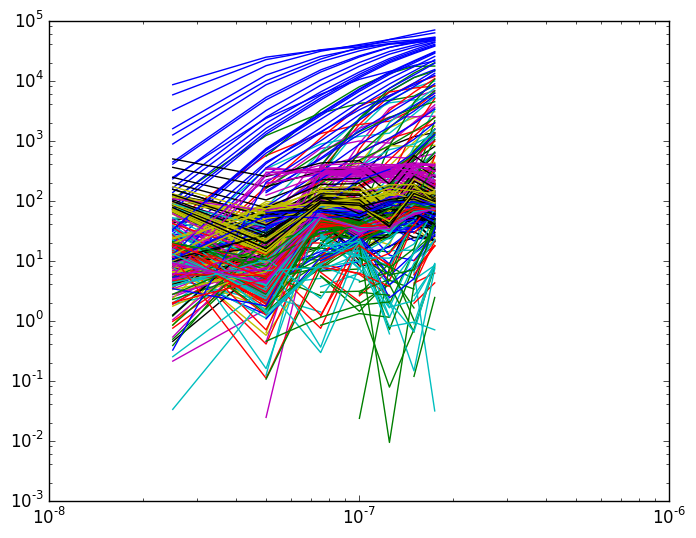

1080

In [155]:
sp = sortperm([RBP.deps for RBP in RBPv])
spt = convert(Array{Bool,1},[(RBP.deps < 1e-6) for RBP in RBPv[sp]]) 
sp = sp[spt]
#sp = sp[(RBP.deps < 1e-6) for RBP in RBPv[sp]]
for i = [1:1080][DiscreteMaps.sdvs .> 0]
    loglog([RBP.deps for RBP in RBPv][sp],[(RBP.chisq[i])-(RBP.M-2) for RBP in RBPv][sp],"-")
    hold(true)
end
#axis([(10^-8),(10^-4),1.,10^4])
length(RBPv[1].chisq)

1080-element BitArray{1}:
  true
 false
 false
  true
 false
 false
  true
 false
  true
 false
 false
  true
 false
     ⋮
 false
  true
  true
 false
  true
 false
  true
  true
 false
  true
 false
  true